-------------------------------------------------------------------
# Homework set 11 - solution

 * **Author**: Balint Szoke
 * **UniID**: bs2574

> This notebook replicates Figure 1 of the paper *Stochastic Stability 
in Monotone Economies* by Takashi Kamihigashi and John Stachurski

-------------------------------------------------------------------


In [1]:
%matplotlib inline

import numpy as np
import scipy as sp

from scipy.stats import norm
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection

### Optimal exploitation of a renewable resource

Planner maximizes
$$\max \mathbb{E} \sum_{t=0}^{\infty} \beta^t u(c_t)\quad \quad \text{s.t. }\quad y_{t+1} = \xi_{t}f(y_t-c_t),\quad \xi_t \stackrel{iid}{\sim} \log\mathcal{N}(-0.1, 0.2) $$
where 
 * $y_t\in S \equiv (0,\infty)$ is the stock of the resource. Let's define the state variable as $Y_t \equiv \log y_t \in (-\infty, \infty)$
 * $c_t \in [0, y_t]$ is consumption
 * $f(\cdot)$ is the growth function for the resource
 
In the class below the following functional forms are used
\begin{align}
u(c) &= 1 - \exp(-\theta c^{\gamma}) \\
f(y) &= l(y)y^{\alpha}, \quad \text{where}\quad l(y) = a + \frac{b-a}{1 + \exp(-c(y-d))}
\end{align} 

**Methods:**
 * fitted policy function iteration to solve for optimal policies $\sigma(y_t)$
 * look-ahead estimator to compute stationary densities given the policies

In [2]:
class Renewable_model(object):
    
    def __init__(self, alpha, gamma, theta, a, b, c, d, mu, sd, 
                 y_min = np.exp(-2), y_max = 6, y_size = 50):
        
        # Parameters of the functions
        self.alpha, self.gamma, self.theta = alpha, gamma, theta
        self.a, self.b, self.c, self.d = a, b, c, d
        self.mu, self.sd = mu, sd
        
        # Parameters of the grid
        self.y_min, self.y_max = y_min, y_max
        self.y_size = y_size
        
        # Construct a grid which is uniform in LOG(y)
        self.Y_grid = np.linspace(np.log(self.y_min), np.log(self.y_max), self.y_size)
        
        
    def _u(self, cons):
        """
        Per period utility function        
        """
        theta, gamma = self.theta, self.gamma
        
        return 1 - np.exp(-theta*cons**gamma)
    
    
    def _f(self, y):
        """
        Growth function for the resource in terms of y (not log!)
        """
        a, b, c, d = self.a, self.b, self.c, self.d
        alpha = self.alpha
        l_y = a + (b - a)/(1 + np.exp(-c * (y - d)))
        
        return l_y * y**alpha

    
    def transition_kernel(self, Y, c):
        """
        Transition kernel which returns the conditional distribution
        of tomorrow's state conditional on 
            Y   : the current log state 
            c   : today's action (not log!) 
        """
        
        N = self.y_size
        d = self.Y_grid[1] - self.Y_grid[0]
        
        dist_log_xi = norm(self.mu, self.sd)
        y_t =  np.exp(Y)
        
        if y_t == c:
            zero_next = np.zeros(N)
            zero_next[0] = 1.0
            
            return zero_next
        
        else:
            p = np.zeros(N)
            for i_y, Y in enumerate(self.Y_grid):                
                Y_next_pd = (Y + d/2) - np.log(self._f(y_t - c))
                Y_next_md = (Y - d/2) - np.log(self._f(y_t - c))

                if i_y == 0:
                    p[i_y] = dist_log_xi.cdf(Y_next_pd)

                elif i_y == N-1: 
                    p[i_y] = 1 - dist_log_xi.cdf(Y_next_md)                

                else:
                    p[i_y] = dist_log_xi.cdf(Y_next_pd) - dist_log_xi.cdf(Y_next_md)
            
            return p 
        
    
    def transition_matrix(self, sigma):
        """
        Constructing the endogenous transition matrix for a given
        policy function sigma
        """
        
        N = self.y_size
        P = np.zeros((N, N))
                
        for i_y, Y in enumerate(self.Y_grid):        
            P[i_y, :] = self.transition_kernel(Y, sigma[i_y])
        
        return P
    
    
    def value_func(self, beta, sigma):
        """
        Compute the value function using the Neumman-operator for a particular
        
        beta  : discount factor, scalar (0,1) 
        sigma : policy function, nparray with len(sigma) == y_size
        """
        
        N = self.y_size
        P = self.transition_matrix(sigma)
        
        v_sigma = np.linalg.inv(np.eye(N) - beta*P) @ self._u(sigma)
        
        return v_sigma
    

    def v_greedy(self, beta, Y, v):
        """
        For a given log state Y and value function v, this method calculates 
        the v-greedy policy using a numerical optimizer 
        """
        
        res = sp.optimize.minimize_scalar(lambda c: -self._aux_func(c, beta, Y, v), 
                                          method = 'Bounded', 
                                          bounds = (0, np.exp(Y)))
        return res.x
    

    def _aux_func(self, c, beta, Y, v):
        """
        Auxiliary objective function for the optimizer in self.v_greedy
        """
        return self._u(c) + beta * self.transition_kernel(Y, c) @ v 
    

    def update(self, beta, sigma):
        """
        The method updates the policy function for the Howard algorithm
        """
        
        v = self.value_func(beta, sigma)
        sigma_new = np.zeros(self.y_size)
        
        for i_y, Y in enumerate(self.Y_grid):
            sigma_new[i_y] = self.v_greedy(beta, Y, v)
        
        return sigma_new
    

    def Howard(self, beta, sigma0, tol = 1e-6, max_iter = 100):
        """
        This implements the Howard policy function iteration 
        """
        
        diff = 1
        iteration = 0
        sigma_old = sigma0
        
        while diff > tol and iteration <= max_iter:
            iteration += 1
            sigma_new = self.update(beta, sigma_old)
            diff = max(abs(sigma_new - sigma_old))
            sigma_old = sigma_new
        
        self.sigma = sigma_new
        
        return sigma_new
    
    
    def simulate(self, T, sigma):
        """
        Draw a long path for a given sigma
        """
        N = self.y_size
        
        index_path = np.zeros(T, dtype = int)        
        index_path[0] = 1
        P = self.transition_matrix(sigma)
        
        for t in range(T-1):
            index_path[t + 1] = np.random.choice(N, 1, p = P[index_path[t], :])

        Y_path = self.Y_grid[index_path]
        
        return index_path, Y_path 
    
    
    def look_ahead(self, T, sigma, burn_in = 0):
        """
        The look-ahead estimator for the stationary distribution
        """
        index_path, Y_path = self.simulate(T, sigma)
        p_sum = np.zeros(self.y_size)
        ii = 0
        
        for index, val in zip(index_path, Y_path):            
            if ii >= burn_in:
                p_sum += self.transition_kernel(val, sigma[index])
            ii += 1
        
        return p_sum / (T - burn_in)

## Parameters

In [3]:
# Parameters from the paper
a, b, c, d = 1, 2, 20, 1
theta, gamma, alpha = 0.5, 0.9, 0.5 
mu, sd = -0.1, 0.2

# Details for the figure
num_gridpoints = 50
num_betas = 12
num_simul = 5000
num_burnin = 3000

# Different values for beta
betas = np.linspace(.99, .945, num_betas)

In [4]:
# Renawable model instance with the above parameters
rm = Renewable_model(alpha, gamma, theta, a, b, c, d, mu, sd, y_size = num_gridpoints)

# Store the calculated policies (cols are the policies for different betas)
store_policies = np.zeros((num_gridpoints, num_betas))

## What does the policy function look like as a function of $\beta$?

In [5]:
sigma0 = np.exp(rm.Y_grid)/2            # initial guess

for i, beta in enumerate(betas):
    print("Beta = {:1.3f} is running".format(beta))
    store_policies[:, i] = rm.Howard(beta, sigma0)

Beta = 0.990 is running
Beta = 0.986 is running
Beta = 0.982 is running
Beta = 0.978 is running
Beta = 0.974 is running
Beta = 0.970 is running
Beta = 0.965 is running
Beta = 0.961 is running
Beta = 0.957 is running
Beta = 0.953 is running
Beta = 0.949 is running
Beta = 0.945 is running


Plot the policy functions for different discount factors

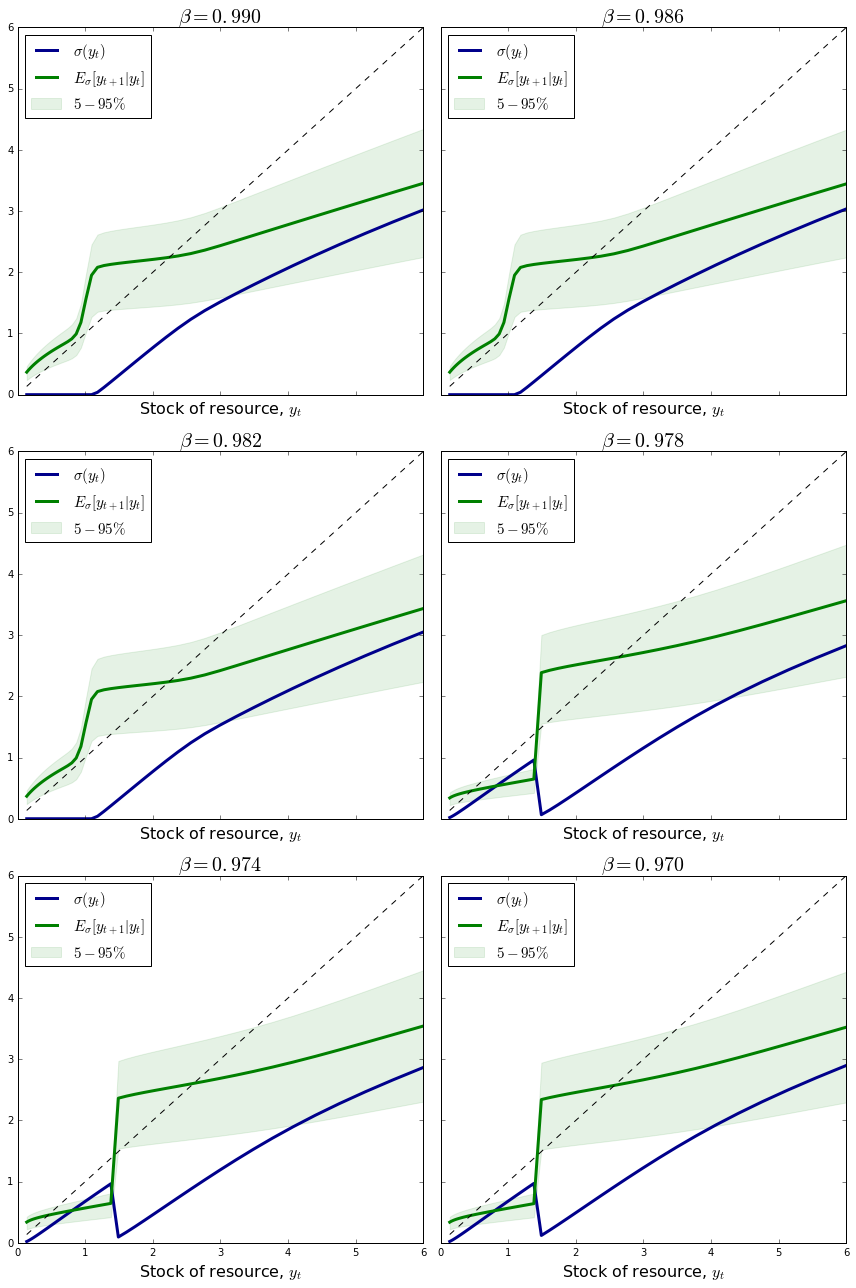

In [7]:
fig, axes = plt.subplots(3, 2, figsize = (12, 18), sharex = True, sharey = True)
y_grid = np.exp(rm.Y_grid)

for i, ax in enumerate(axes.flat):

    f_val = np.log(rm._f(y_grid - store_policies[:, i*2]))
    
    ax.plot(y_grid, store_policies[:, i*2], lw = 3, label = r'$\sigma(y_{t})$', color = 'DarkBlue')
    ax.plot(y_grid, np.exp(f_val), lw = 3, label = r'$E_{\sigma}[y_{t+1} | y_t]$', color = 'g')
    
    logn_dist = sp.stats.lognorm(s = rm.sd, scale = np.exp(rm.mu + f_val))       
    ax.fill_between(y_grid, logn_dist.ppf(.05), logn_dist.ppf(.95), alpha = .1, 
                    color="g", label = r"$5-95\%$")
    ax.plot(y_grid, y_grid, color = 'k', linestyle = '--')
    ax.set_xlabel(r'Stock of resource, $y_t$', fontsize = 16)
    ax.set_title(r'$\beta={:1.3f}$'.format(betas[i]), fontsize = 20)
    ax.legend(loc = 'best', fontsize = 15)
    
plt.tight_layout()

## 3D plot of stationary distributions as a function of $\beta$

In [8]:
store_densities = np.zeros((num_gridpoints, num_betas))

for i in range(num_betas):
    print("Iteration = {:f}".format(i))
    store_densities[:, i] = rm.look_ahead(num_simul, store_policies[:, i], burn_in = num_burnin)

Iteration = 0.000000
Iteration = 1.000000
Iteration = 2.000000
Iteration = 3.000000
Iteration = 4.000000
Iteration = 5.000000
Iteration = 6.000000
Iteration = 7.000000
Iteration = 8.000000
Iteration = 9.000000
Iteration = 10.000000
Iteration = 11.000000


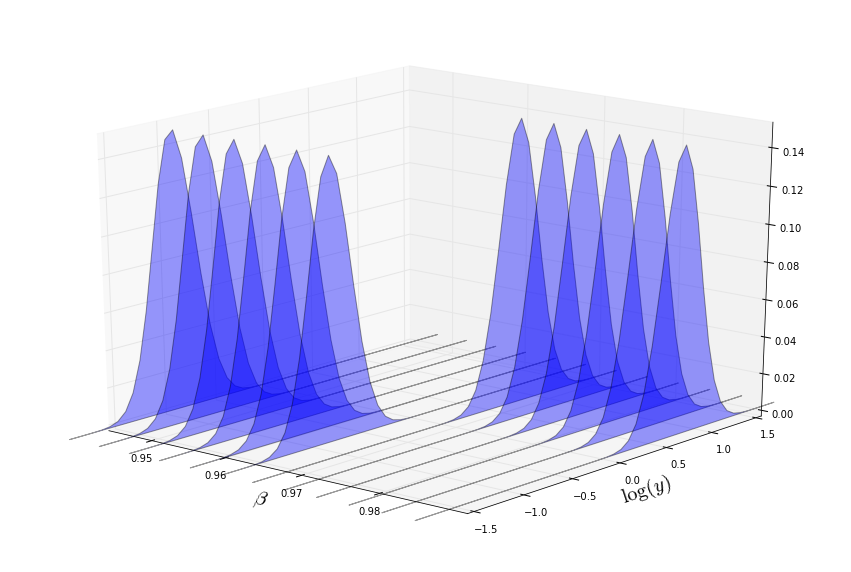

In [9]:
fig = plt.figure(figsize = (15, 10))
ax = fig.gca(projection = '3d')

x = rm.Y_grid
verts = []

for i, beta in enumerate(betas):
    y = store_densities[:, i]
    verts.append(list(zip(x, y)))

poly = PolyCollection(verts)
poly.set_alpha(0.4)
ax.add_collection3d(poly, zs = betas, zdir = 'x')

ax.set_xlabel(r'$\beta$', fontsize = 20)
ax.set_xlim3d(.945, .99)
ax.set_ylabel(r'$\log(y)$', fontsize = 20)
ax.set_ylim3d(-1.5, 1.5)
ax.set_zlim3d(0, .15)

# Angle
ax.view_init(20, 310)